In [29]:
# important libaries 

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [30]:
# read in the data 

df = pd.read_csv("merged_data/merged.csv")
df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Year,Genre,Runtime,...,T,TECH,UBER,VIAC,VOYA,WIX,XOM,YETI,ZION,SPX
0,0,0.42,0.42,0.39,0.40,0.34,678832000.0,1998,121,123.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.42,0.42,0.39,0.40,0.34,678832000.0,1998,110,91.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.28,1.31,1.22,1.25,1.25,71200.0,1998,121,123.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1.28,1.31,1.22,1.25,1.25,71200.0,1998,110,91.0,...,0,0,0,0,0,0,0,0,0,0
4,4,3.02,3.06,2.73,2.78,2.70,4768000.0,1998,121,123.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# clean up the data 

# Log-transform IMDB Votes
df['IMDB Votes'] = np.log(df['IMDB Votes'] + 1)

# Create binary target: 1 if stock goes up, 0 otherwise
df['Adj_Close_diff'] = df['Adj Close'].diff().shift(-1)
df['Adj_Close_up'] = (df['Adj_Close_diff'] > 0).astype(int)

# Drop NA values for modeling
df.dropna(subset=['Year', 'Runtime', 'Metascore', 'IMDB Votes', 'Adj_Close_up'], inplace=True)

# create the dummy varaibles 
rated_dummies = pd.get_dummies(df['Rated'], prefix='Rated')
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')

# Ensure all expected columns exist
expected_dummies = ['RatedG', 'RatedM/PG', 'RatedPG', 'RatedPG-13', 'RatedR', 'Rated-R', 'GenreComedy', 'GenreDrama']
for col in expected_dummies:
    if col.startswith('Rated') and col not in rated_dummies.columns:
        rated_dummies[col] = 0
    elif col.startswith('Genre') and col not in genre_dummies.columns:
        genre_dummies[col] = 0

# Merge dummies into main DataFrame
df_model = pd.concat([df, rated_dummies, genre_dummies], axis=1)

# Add lagged stock features
df_model['Adj_Close_lag1'] = df_model['Adj Close'].shift(1)
df_model['Adj_Close_return'] = df_model['Adj Close'].pct_change()
# Example longer lags
df_model['Adj_Close_lag3'] = df_model['Adj Close'].shift(3)
df_model['Adj_Close_return_3d'] = df_model['Adj Close'].pct_change(periods=3)
df_model['Adj_Close_return_5d'] = df_model['Adj Close'].pct_change(periods=5)



This is for the baseline model - all the features that constanly appeared in the feature selection 

In [13]:
# Choose your best feature set
features = ['Year', 'Runtime', 'Metascore', 'IMDB Votes']  # base_4
X = df_model[features].dropna()
y = df_model.loc[X.index, 'Adj_Close_up']

In [14]:
# scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# perform the mdoel 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_poly = SVC(kernel='poly', degree=2, class_weight='balanced')

f1_scores = cross_val_score(svm_poly, X_scaled, y, cv=cv, scoring='f1_weighted')
print(f"\n SVM (poly) CV F1-score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")



 SVM (poly) CV F1-score: 0.5194 ± 0.0058


now adding lag 

In [15]:
# --- Choose features including lag ---
features = [
    'Year', 'Runtime', 'Metascore', 'IMDB Votes',
    'Adj_Close_lag1', 'Adj_Close_return'
]

# --- Drop NA for modeling ---
df_subset = df_model.dropna(subset=features + ['Adj_Close_up'])

X = df_subset[features]
y = df_subset['Adj_Close_up']

In [16]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



SVM (poly) CV F1-score (train): 0.4395 ± 0.0159


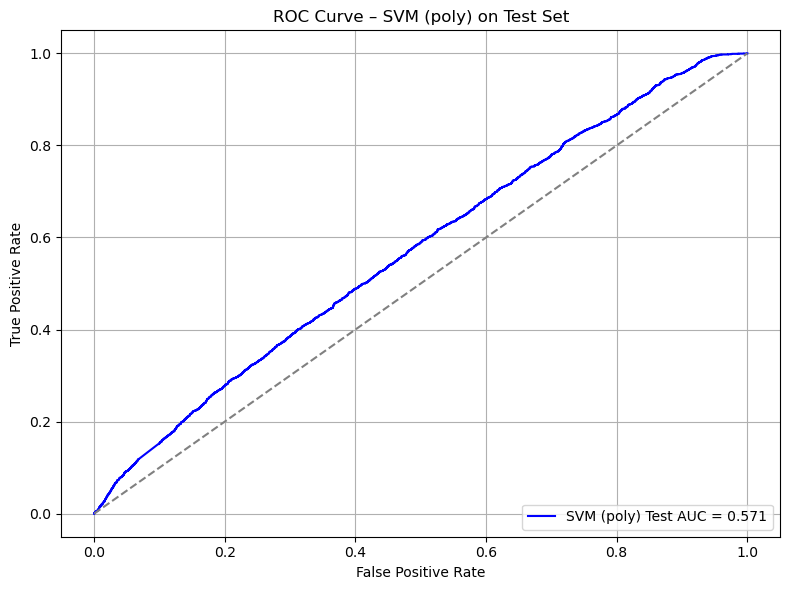

In [17]:
# --- Cross-validate on training set ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_poly = SVC(kernel='poly', degree=2, class_weight='balanced', probability=True)

f1_scores = cross_val_score(svm_poly, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
print(f"\nSVM (poly) CV F1-score (train): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# --- Fit on training, evaluate on test ---
svm_poly.fit(X_train_scaled, y_train)
y_proba = svm_poly.predict_proba(X_test_scaled)[:, 1]

# --- ROC Curve on test set ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"SVM (poly) Test AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM (poly) on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Now running forward_CP_ADJ

In [18]:
# Choose your best feature set
features = ['Year', 'GenreComedy', 'GenreDrama', 'Runtime', 'RatedG', 'RatedM/PG', 'Metascore', 'IMDB Votes','Adj_Close_lag1', 'Adj_Close_return'] 
X = df_model[features].dropna()
y = df_model.loc[X.index, 'Adj_Close_up']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


SVM (poly) CV F1-score (train): 0.4395 ± 0.0159


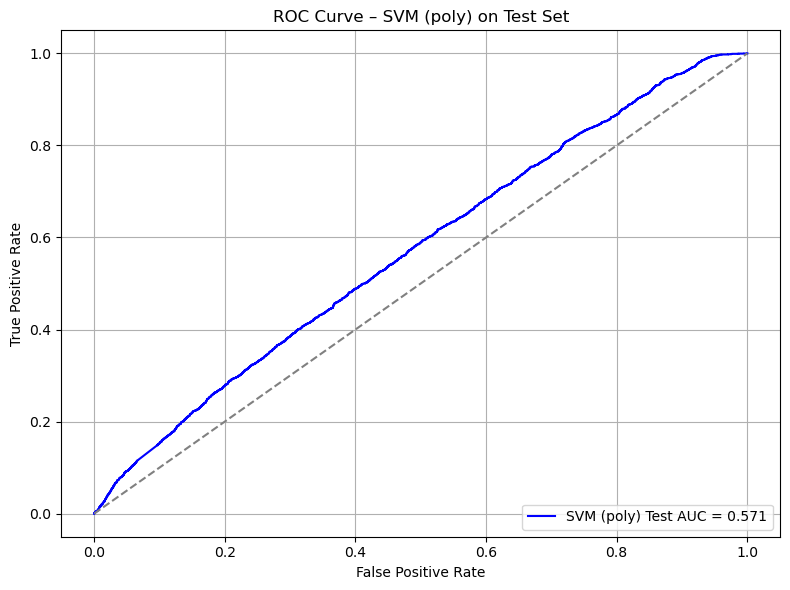

In [19]:
# --- Cross-validate on training set ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_poly = SVC(kernel='poly', degree=2, class_weight='balanced', probability=True)

f1_scores = cross_val_score(svm_poly, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
print(f"\nSVM (poly) CV F1-score (train): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# --- Fit on training, evaluate on test ---
svm_poly.fit(X_train_scaled, y_train)
y_proba = svm_poly.predict_proba(X_test_scaled)[:, 1]

# --- ROC Curve on test set ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"SVM (poly) Test AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM (poly) on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Now going to do the same thing running a logistic regression model 

In [46]:
features = [
    'Year', 'Runtime', 'Metascore', 'IMDB Votes',
    'Adj_Close_lag1', 'Adj_Close_return',
    'Adj_Close_lag3', 'Adj_Close_return_3d', 'Adj_Close_return_5d'
]

# --- Subset and clean data
df_subset = df_model.dropna(subset=features + ['Adj_Close_up'])
X = df_subset[features]
y = df_subset['Adj_Close_up']

# --- Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

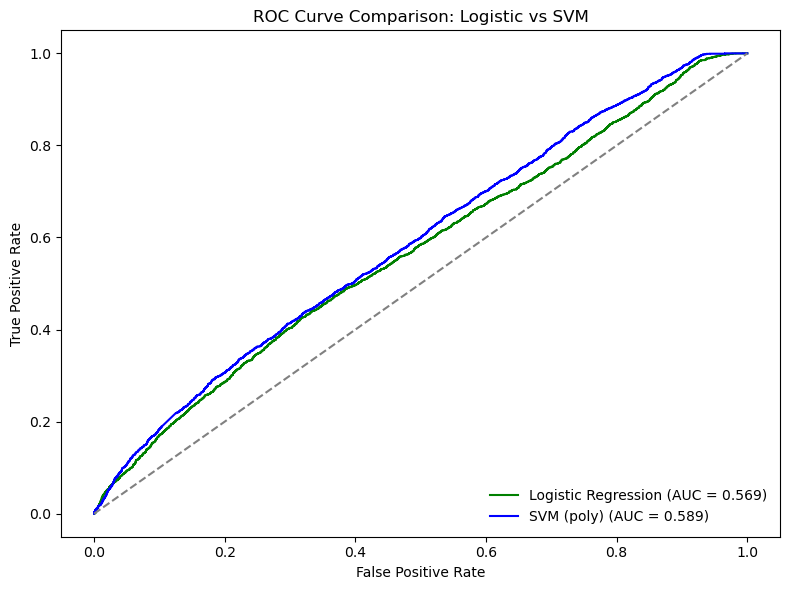

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Logistic Regression
log_model = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_train)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = auc(fpr_log, tpr_log)

# --- SVM (poly)
svm_model = SVC(kernel='poly', degree=2, class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

# --- Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})", color='green')
plt.plot(fpr_svm, tpr_svm, label=f"SVM (poly) (AUC = {auc_svm:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic vs SVM")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()



Logistic Regression CV F1-score (train): 0.5342 ± 0.0037


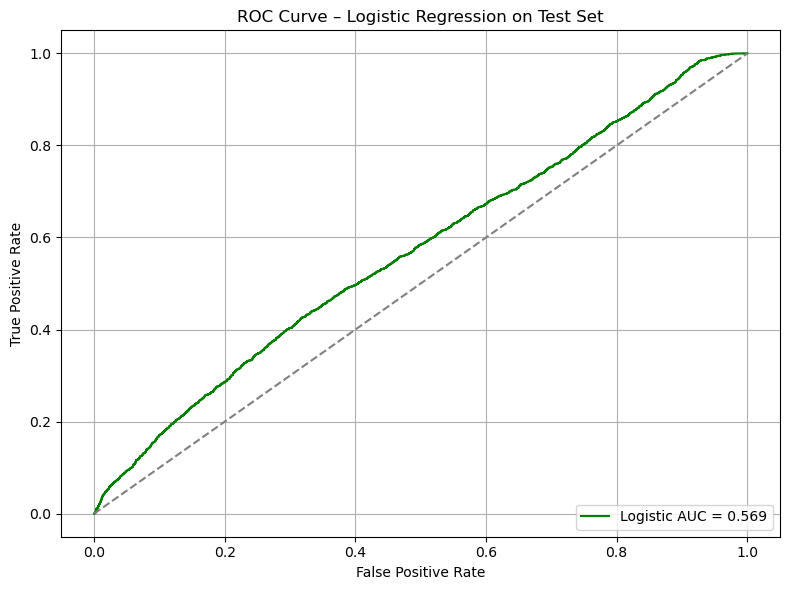

In [39]:
# --- L1 or L2 Logistic Regression
log_model = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')  # swap 'l1' for sparse

# --- Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
print(f"\nLogistic Regression CV F1-score (train): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# --- Fit model and predict probabilities
log_model.fit(X_train_scaled, y_train)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# --- ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# --- Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f"Logistic AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Choose your best feature set
features = ['Year', 'GenreComedy', 'GenreDrama', 'Runtime', 'RatedG', 'RatedM/PG', 'Metascore', 'IMDB Votes','Adj_Close_lag1', 'Adj_Close_return'] 
X = df_model[features].dropna()
y = df_model.loc[X.index, 'Adj_Close_up']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression CV F1-score (train): 0.5193 ± 0.0048


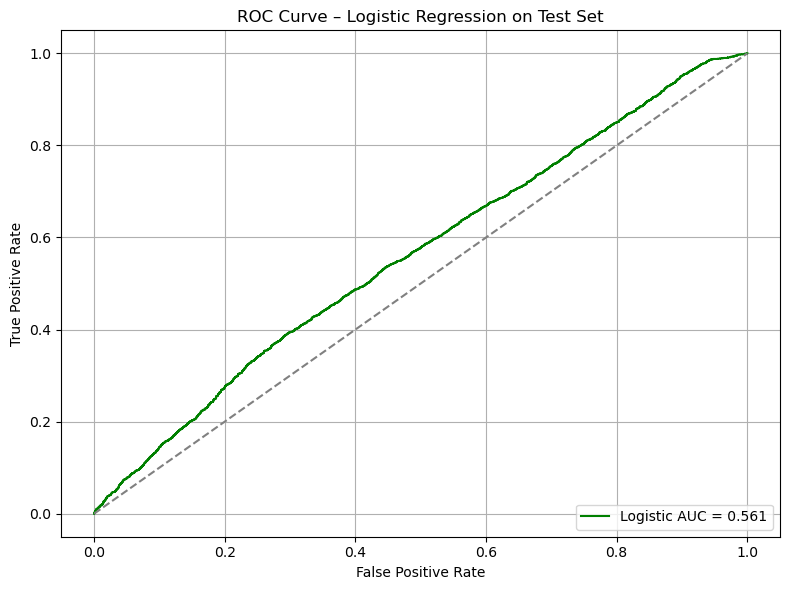

In [33]:
# --- L1 or L2 Logistic Regression
log_model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')  

# --- Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
print(f"\nLogistic Regression CV F1-score (train): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# --- Fit model and predict probabilities
log_model.fit(X_train_scaled, y_train)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# --- ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# --- Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f"Logistic AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:

# Choose your best feature set
features = ['Year', 'Runtime', 'RatedG', 'RatedPG', 'RatedPG-13', 'Rated-R', 'Metascore', 'IMDB Votes','Adj_Close_lag1', 'Adj_Close_return'] 
X = df_model[features].dropna()
y = df_model.loc[X.index, 'Adj_Close_up']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression CV F1-score (train): 0.5193 ± 0.0048


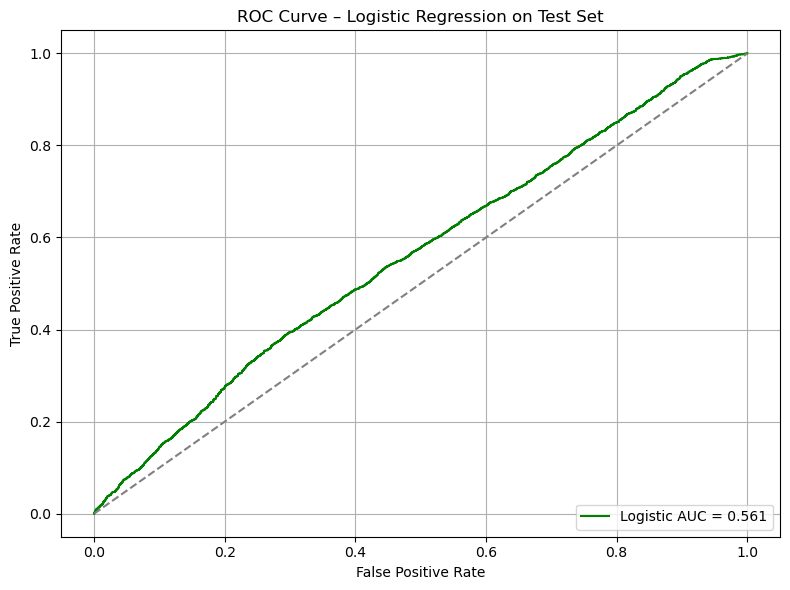

In [28]:
# --- L1 or L2 Logistic Regression
log_model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')  

# --- Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
print(f"\nLogistic Regression CV F1-score (train): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# --- Fit model and predict probabilities
log_model.fit(X_train_scaled, y_train)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# --- ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# --- Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f"Logistic AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

try one regression - just to see 

In [50]:
features = [
    'Year', 'Runtime', 'Metascore', 'IMDB Votes',
    'Adj_Close_lag1', 'Adj_Close_return',
    'Adj_Close_lag3', 'Adj_Close_return_3d', 'Adj_Close_return_5d'
]

# --- Subset and clean data
df_subset = df_model.dropna(subset=features + ['Adj_Close_diff'])
X = df_subset[features]
y = df_subset['Adj_Close_diff']

# --- Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=42
)

# --- Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression Results:
  RMSE: 290.20230
  MAE : 110.50980
  R²  : 0.1694


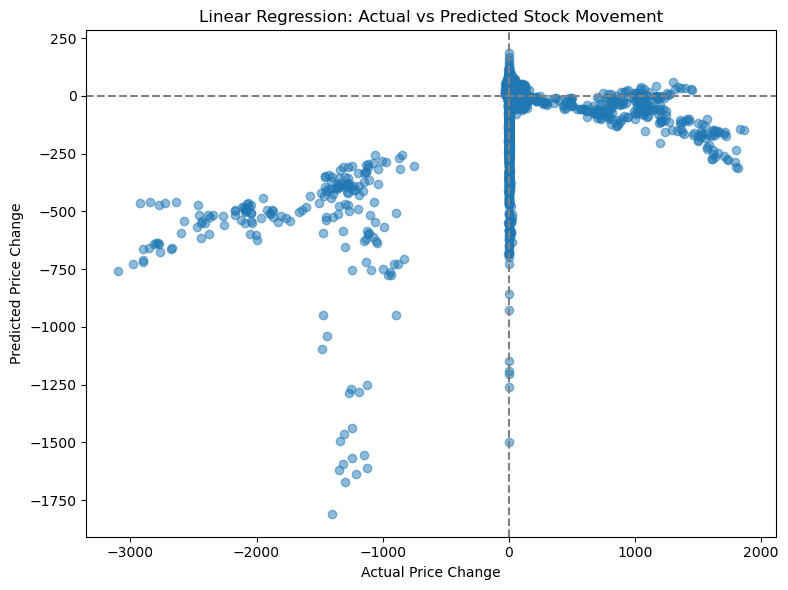

In [51]:
# --- Fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# --- Predict
y_pred = linreg.predict(X_test_scaled)

# --- Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Results:")
print(f"  RMSE: {rmse:.5f}")
print(f"  MAE : {mae:.5f}")
print(f"  R²  : {r2:.4f}")

# --- Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Actual Price Change")
plt.ylabel("Predicted Price Change")
plt.title("Linear Regression: Actual vs Predicted Stock Movement")
plt.tight_layout()
plt.savefig("regression.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [42]:
from sklearn.linear_model import Ridge, Lasso

# --- Define models with default alpha (regularization strength)
ridge = Ridge(alpha=1.0)   # You can tune alpha later
lasso = Lasso(alpha=0.01)  # Start with small alpha for Lasso (can zero out features too aggressively)

# --- Fit both models
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

# --- Predict
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)

# --- Evaluate
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Regression Results:")
    print(f"  RMSE: {rmse:.5f}")
    print(f"  MAE : {mae:.5f}")
    print(f"  R²  : {r2:.4f}")

evaluate_model("Ridge", y_test, y_pred_ridge)
evaluate_model("Lasso", y_test, y_pred_lasso)


📊 Ridge Regression Results:
  RMSE: 0.48816
  MAE : 0.47785
  R²  : 0.0225

📊 Lasso Regression Results:
  RMSE: 0.48908
  MAE : 0.48100
  R²  : 0.0189
